<a href="https://colab.research.google.com/github/BecomeAllan/ML-SLRC/blob/main/Classification_automation_SLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install S2query
!pip install transformers==4.16.2
!pip install torchmetrics==0.8.0

!pip install matplotlib==3.5.1

  Created wheel for S2query: filename=S2query-1.0.1-py3-none-any.whl size=13813 sha256=c843a668df130e3a24e002f7982cbcfee22a3092d1b6054f60e7450424bfb8c9
  Stored in directory: c:\users\allan\appdata\local\pip\cache\wheels\16\87\59\f01b72693eb67c28785084e6719cf77a38d44b266a6363ac35
Successfully built S2query
Note: you may need to restart the kernel to use updated packages.


# Search no Semantic scholar

## Utilizando a API para fazer a busca de dados

In [ ]:
from S2query import S2paperAPI

import pandas as pd
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output
import unicodedata
import re
import time


class SearcherAPI():
  def __init__(self):
    # cria o objeto para puxar os dados
    self.obj = S2paperAPI()

    # Cria os buttoes/textbox
    self.search_b = widgets.Button(description="Search")
    self.search_text =  widgets.Textarea(
    value='artificial intelligence+Deep Learning',
    placeholder='Type something',
    # description=':',
    disabled=False
)
    # Configura a localizacao dos botoes/textbox
    self.hbox = widgets.HBox([self.search_b, self.search_text])    
    
    # Funcao quando clicar o botao
    self.search_b.on_click(self.search_button)


  # Search button
  def search_button(self, p):
    print(self.search_text.value)
    # Busca os dados
    self.obj.get(self.search_text.value, n=100, sort = "total-citations", fieldsOfStudy = ['biology'])

    # Guarda os dados achados
    self.data = self.obj.all
  
  # Funcao para chamar a classe
  def __call__(self):
    clear_output()
    # Mostra os butoes
    display(self.hbox)

    

result = SearcherAPI()
result()

In [ ]:
result.data.head()

## Utilizando a Web para fazer a busca de dados

In [200]:
from S2query import S2paperWeb


import pandas as pd
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output
import unicodedata
import re
import time


class SearcherWeb():
  def __init__(self):
    # cria o objeto para puxar os dados
    self.obj = S2paperWeb()

    # Cria os buttoes/textbox
    self.search_b = widgets.Button(description="Search")
    self.search_text =  widgets.Textarea(
    value='artificial intelligence+Deep Learning',
    placeholder='Type something',
    # description=':',
    disabled=False
)
    # Configura a localizacao dos botoes/textbox
    self.hbox = widgets.HBox([self.search_b, self.search_text])

    # Funcao quando clicar o botao
    self.search_b.on_click(self.search_button)


  # Search button
  def search_button(self, p):
    print(self.search_text.value)
    # Busca os dados
    self.obj.get(self.search_text.value, n=100,
                 sort = "relevance", fieldsOfStudy = [],
                 publicationTypes = ['JournalArticle'])

    # Guarda os dados achados
    self.data = self.prepare_data(self.obj.all)
  
  # cria um subset dictionary da funcao que busca os dados
  def subset(self, dicttosub):
    # Seleciona apenas ('title','paperAbstract','year', 'links')
    subdict = {k:dicttosub[k] for k in ('title','paperAbstract','year', 'links')}

    # Renomeia a key do dictionar
    subdict['abstract'] = subdict.pop('paperAbstract')
    
    # Guarda apenas um link de referencia
    try:
      subdict['links'] = subdict['links'][0]['url']
    except:
      subdict['links'] = np.nan
    return subdict

  # Trata os dados para transformar de json para pandas.dataframe
  def prepare_data(self, data):

    # Loop sobre os resultados para selecionar tudo em uma lista
    papers = []
    for x in data['Results']:
      papers_page = [self.subset(paper) for paper in x['Page']['Papers']]
      papers.append(papers_page)
    papers = list(chain.from_iterable(papers))

    # Transforma em Pandas
    data = pd.DataFrame(papers)
    return data
  
  # Funcao para chamar a classe
  def __call__(self):
    clear_output()
    # Mostra os butoes
    display(self.hbox)


result = SearcherWeb()
result.hbox
result()

'Deep Learning'+ 'citation screening classification'


Searching...


[_runtime]>> Start searching...

 ---
Total Results: 898
Total Pages: 89
Query Suggestions: []
--- 

[_extract] >> extracting relevant data.
[_extract]>> Took 0.57s
[_runtime]>> Took 5.64s
[get]>> Took 5.66s
'citation screening automation'


Searching...


[_runtime]>> Start searching...
[_extract] >> extracting relevant data.
[_extract]>> Took 0.52s
[_runtime]>> Took 5.01s
[get]>> Took 5.04s


In [204]:
result.data.head(10)

,title,year,links,abstract
0,Automation of Citation Screening for Systemati...,2022,https://arxiv.org/pdf/2201.07534.pdf,In the process of Systematic Literature Review...
1,An open-source integrated framework for the au...,2022,https://arxiv.org/pdf/2202.10033.pdf,The exponential growth of scientific literatur...
2,Usability and acceptability of four systematic...,2019,https://doi.org/10.1186/s13643-019-1069-6,AimNew software packages help to improve the e...
3,Reporting Statistical Validity and Model Compl...,2017,http://dl.acm.org/citation.cfm?id=3084283,Background:: Statistical validity and model co...
4,Crowdsourcing citation-screening in a mixed-st...,2021,https://doi.org/10.1186/s12874-021-01271-4,Background Crowdsourcing engages the help of l...
5,Training sample selection: Impact on screening...,2021,https://doi.org/10.1002/jrsm.1518,"When performing a systematic review, researche..."
6,Machine Learning Assisted Citation Screening f...,2020,https://www.ncbi.nlm.nih.gov/pubmed/32570395,Evidence-based practice is highly dependent up...
7,Citation screening using crowdsourcing and mac...,2020,https://www.ncbi.nlm.nih.gov/pubmed/33007457,
8,Using a neural network-based feature extractio...,2020,https://doi.org/10.1016/j.eswax.2020.100030,
9,Crowdsourcing the Citation Screening Process f...,2019,https://pdfs.semanticscholar.org/9917/a96c4a4c...,Background Systematic reviews (SRs) are often ...


# Classificação dos dados não rotulados

primeira classificação dos dados para poder treinar o modelo

In [313]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output, Markdown
import unicodedata
import re
import time
from scipy.stats import poisson



class Judger():
  def __init__(self, data, configure_text= True):
    self.data = data

    self.selected_indx = []
    self.included_count = 0
    self.excluded_count = 0
    
    if configure_text:
      # cria uma coluca no data como text (title + abstract) para ser classificado pelo oraculo
      self.data.fillna(value='', inplace=True)
      self.data['text'] = self.data['title']  +'. ' + self.data['abstract']
      self.data['label'] = np.nan

    # Cria os buttoes
    self.Included = widgets.Button(description="Included")
    self.NIncluded = widgets.Button(description="Not Included")
    self.pass_b = widgets.Button(description="Pass")

    # Configura a localizacao dos botoes
    self.hbox = widgets.HBox([self.NIncluded, self.Included, self.pass_b])    
    
    # Funcao quando clicar o botao
    self.Included.on_click(self.Included_button)
    self.NIncluded.on_click(self.Not_Included_button)
    self.pass_b.on_click(self.pass_button)


  # Incluir na revisao button
  def Included_button(self, p):
    self.data.loc[self.index, 'label'] = 'positive'
    self.included_count += 1
    self.__call__()

  # Excluir da revisao button
  def Not_Included_button(self, p):
    self.data.loc[self.index, 'label'] = 'negative'
    self.excluded_count += 1
    self.__call__()

  # Excluir da revisao button
  def pass_button(self, p):
    self.__call__()
  
  def __call__(self):
    clear_output()
    # Quais dados sao nao  rotulados
    criteria_na = self.data['label'].isna()

    # Se acabar de rotular todos os dados
    if sum(criteria_na) == 0:
      return print('Finish')

    # Index aleatorio para selecionar um texto para classificacao
    indexs_unlabeled = self.data.loc[criteria_na].index
    prob = poisson.cdf(indexs_unlabeled, mu=1)
    prob = prob/sum(prob)
    self.index = np.random.choice(indexs_unlabeled, 1,
                                  replace=False,
                                  p = prob
                                  ).item()

    # Guarda qual index foi separado pra classificar
    self.selected_indx.append(self.index)

    # Texto e Label do index aleatorio
    text = self.data.loc[self.index, 'text']
    label = self.data.loc[self.index, 'label']
    
    
    # Print de alguns resultados
    print('Unlabed:', sum(criteria_na))
    print(
          "Not included examples:", self.excluded_count,"|",
          "Included examples:", self.included_count)
    display(self.hbox)
    print('Previos Label:', label)
    print('Text:')
    display(Markdown(text))


In [216]:
Judged = Judger(result.data)

Judged()

Unlabed: 86
Not included examples: 10 | Included examples: 4


Previos Label: nan
Text:


Computational Discovery of Transition-metal Complexes: From High-throughput Screening to Machine Learning.. Transition-metal complexes are attractive targets for the design of catalysts and functional materials. The behavior of the metal-organic bond, while very tunable for achieving target properties, is challenging to predict and necessitates searching a wide and complex space to identify needles in haystacks for target applications. This review will focus on the techniques that make high-throughput search of transition-metal chemical space feasible for the discovery of complexes with desirable properties. The review will cover the development, promise, and limitations of "traditional" computational chemistry (i.e., force field, semiempirical, and density functional theory methods) as it pertains to data generation for inorganic molecular discovery. The review will also discuss the opportunities and limitations in leveraging experimental data sources. We will focus on how advances in statistical modeling, artificial intelligence, multiobjective optimization, and automation accelerate discovery of lead compounds and design rules. The overall objective of this review is to showcase how bringing together advances from diverse areas of computational chemistry and computer science have enabled the rapid uncovering of structure-property relationships in transition-metal chemistry. We aim to highlight how unique considerations in motifs of metal-organic bonding (e.g., variable spin and oxidation state, and bonding strength/nature) set them and their discovery apart from more commonly considered organic molecules. We will also highlight how uncertainty and relative data scarcity in transition-metal chemistry motivate specific developments in machine learning representations, model training, and in computational chemistry. Finally, we will conclude with an outlook of areas of opportunity for the accelerated discovery of transition-metal complexes.

In [218]:
data = Judged.data.loc[:,['label', 'text']]
data.head()

,label,text
0,NaN,Automation of Citation Screening for Systemati...
1,NaN,An open-source integrated framework for the au...
2,NaN,Usability and acceptability of four systematic...
3,NaN,Reporting Statistical Validity and Model Compl...
4,NaN,Crowdsourcing citation-screening in a mixed-st...


# Treinando o modelo para rotular os dados nao rotulados

In [219]:
%matplotlib inline
import torch.nn.functional as F
import torch.nn as nn
import math
import torch
import numpy as np
import pandas as pd
import time
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.manifold import TSNE
from copy import deepcopy, copy
import seaborn as sns
import matplotlib.pylab as plt
from pprint import pprint
import shutil
import datetime
import re
import json
from pathlib import Path

SEED = 2222

gen_seed = torch.Generator().manual_seed(SEED)

##  Baixa o modelo pre-treinado ML-SLRC

In [220]:
path = 'Modelos/Meta-Model/2022_04_26_hr_19_54_15(GOOD)_avaliation/'

model_path = path + 'model.pt'
info_path = path + 'Info.pt'

In [221]:
from ML_SLRC import SLR_Classifier, Encoder, SLR_DataSet

# Baixa o modelo
model = torch.load(model_path)

In [222]:
from Util_funs import train_loop, prepare_data

# Baixa as meta informações do modelo treinado
with open("Modelos/Meta-Model/2022_04_20_hr_01_11_57/"+ "Info.json", 'r') as f:
  Info = json.load(f)


# Configura algumas meta informações
Info["tokenizer"] = AutoTokenizer.from_pretrained(Info['model'],
                                          do_lower_case = True)
Info['tresh'] = 0.9
Info["inner_update_step_eval"] = 3
Info["inner_print"] = 1

## Treina o modelo

In [224]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output, Markdown
import unicodedata
import re
import time

# Tipo de device para colocar o modelo  (GPU, CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Train():
  def __init__(self, model, data, device, Info):
    self.data = data
    self.model = model
    self.Info= Info
    self.device = device

    self.index = 0

    # Cria o butao
    self.train_b = widgets.Button(description="Train")
    
    # Configura a localizacao dos botoes
    self.hbox = widgets.HBox([self.train_b])
    
    # Funcao quando clicar o botao
    self.train_b.on_click(self.train_button)



  # Train button
  def train_button(self, p):
    # Pre-processa os textos dos dados para passar no modelo
    self.data_train_loader, self.data_test_loader, self.data_train, self.data_test = prepare_data(self.data,
              train_size_per_class = 4,
              batch_size = {'train': self.Info['inner_batch_size'],
                            'test': 2},
              max_seq_length = self.Info['max_seq_length'],
              tokenizer = self.Info['tokenizer'],
              input = "text",
              output = "label")

    
    # Treina o modelo e pega o vetor da camada classifier
    self.logits, _, _, _ = train_loop(self.data_train_loader, self.data_test_loader,
                                                        self.model, self.device,
                                                        epoch = self.Info['inner_update_step'],
                                                        lr=self.Info['inner_update_lr'],
                                                        print_info=True,
                                                        name = '')


    # Sigmoid para deixar entre 0 e 1 a confiança das predições
    predictions = torch.sigmoid(self.logits) 

    # Guarda as predições nos dados de teste
    self.data_test['prediction'] = predictions

    self.__call__()

  
  def __call__(self):
    clear_output()

    display(self.hbox)



t = Train(model,data, device, Info)

t()

In [229]:
t.data_test.sample(5)

,label,text,prediction
31,NaN,Mapping the Evolution of Intellectual Structur...,0.700490
50,NaN,Biased Diversity for Effective Virtual Screeni...,0.761099
19,NaN,A critical analysis of studies that address th...,0.788997
7,NaN,Citation screening using crowdsourcing and mac...,0.731751
92,NaN,Systematic screening and assessment of psychos...,0.492829


# Utilizando o modelo treinado para rankear as predições

In [230]:
# Classe que passa pelos textos para avaliar o criterio de rankeamento e classificacao do modelo
class Ranker():
  def __init__(self, data_test, treshold):
    self.treshold = treshold
    self.data = data_test.reset_index().drop("index", axis=1)

    self.index = 0

    # Cria os butoes
    self.next_b = widgets.Button(description="Next")
    self.previous_b = widgets.Button(description="Previous")

    # Configura a localizacao dos botoes
    self.hbox = widgets.HBox([self.previous_b, self.next_b])    

    # Funcao quando clicar nos botoes
    self.next_b.on_click(self.next_button)
    self.previous_b.on_click(self.prev_button)


  # Next button
  def next_button(self, p):
    # Testa se é possivel ir pro proximo texto
    try:
      self.index +=1
      text = self.data.loc[self.index, 'text']
    except:
      self.index =0

    self.__call__()

  # Prev button
  def prev_button(self, p):
    # Testa se é possivel ir pro texto anterior
    try:
      self.index -=1
      text = self.data.loc[self.index, 'text']
    except:
      self.index = len(self.data) - 1

    
    self.__call__()


  def __call__(self):
    clear_output()

    # Mostra os butoes
    display(self.hbox)

    # Pega o texto e a predicao do indice para avaliacao
    text = self.data.loc[self.index, 'text']
    prediction = self.data.loc[self.index, 'prediction']
    label = self.data.loc[self.index, 'label']

    # Mostra alguns resultados
    print('Label:', label)
    print('Prediction:', prediction)
    print('Included:', self.treshold <= prediction)
    print('Text:')
    display(Markdown(text))



In [231]:
r = Ranker(t.data_test, 0.5)
r()

Label: nan
Prediction: 0.71615773
Included: True
Text:


Usability and acceptability of four systematic review automation software packages: a mixed method design. AimNew software packages help to improve the efficiency of conducting a systematic review through automation of key steps in the systematic review. The aim of this study was to gather qualitative data on the usability and acceptability of four systematic review automation software packages (Covidence, SRA-Helper for EndNote, Rayyan and RobotAnalyst) for the citation screening step of a systematic review.MethodsWe recruited three volunteer systematic reviewers and asked them to use allocated software packages during citation screening. They then completed a 12-item online questionnaire which was tailored to capture data for the software packages used.FindingsAll four software packages were reported to be easy or very easy to learn and use. SRA-Helper for EndNote was most favoured by participants for screening citations and Covidence for resolving conflicts. Overall, participants reported that SRA-Helper for EndNote would be their software package of choice, primarily due to its efficiency.ConclusionThis study identified a number of considerations which systematic reviewers can use as a basis of their decision which software to use when performing the citation screening and dispute resolution steps of a systematic review.

In [238]:
ranked_test_data = t.data_test.sort_values('prediction', ascending=False)

r = Ranker(ranked_test_data, treshold=0.5)
r()

Label: nan
Prediction: 0.36683965
Included: False
Text:


Newborn Screening for Congenital Hypothyroidism-Clinical Evaluation and Comparison of Two Different Test Kits for the Determination of TSH in Dried Blood Samples on Two Different Platforms. Newborn screening (NBS) for congenital hypothyroidism (CH) started in the 1970s, with the introduction of radioimmuno assays (RIA) for the measurement of thyroxine (T4), and thyroid stimulating hormone (TSH). With the development of sensitive enzyme immune assays (EIA, FIA, FEIA), RIAs were replaced in the newborn screening laboratories. With the increasing number of analytes and centralization of NBS, there is a growing demand of total automation. In the course of method validation, two fully automated platforms for the determination of TSH in dried blood samples (DBS) were compared. The GSP from PerkinElmer (PE), and the NS2400 from Labsystems (LDx), together with the recommended test kits from both manufacturers. Both systems showed good performance, with recoveries, of 103.0% (LDx) and 98.5% (PE), and CVs for intra and interassay variations at various concentrations, between 4.3 and 15.7. Both assays had a good correlation (r2 = 0.8814). With LDx/NS2400 platform, TSH values were in the mean 2.09 mU/L higher; however, the difference of both results from the mean was within ±2 SD, up to 30 mU/L, and only for values above 50 mU/L did the difference become bigger. However, this has no influence on the clinical interpretation. No false negative results were observed with either of the two platforms. TSH results obtained with the LDx/NS2400 were slightly higher than those obtained with the PE/GSP; however, the recall rate was lower: 0.059% compared to 0.063%. This can be explained by the much narrower distribution of TSH values. In conclusion, both platforms are equally suitable for medium and large NBS laboratories. However, due to the more open structure the LDx/NS2400 platform has a lot of advantages compared to the totally closed PE/GSP platform.

<AxesSubplot:>

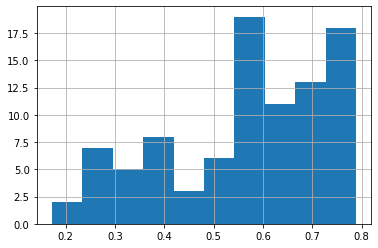

In [237]:
t.data_test['prediction'].hist()

# Active Learning (Apenas um teste)

In [393]:
from scipy import stats
class active_learning(Judger):
  def __init__(self, data):
    self.data = data
    # print(self.data['label'])
    super(active_learning, self).__init__(data = self.data, configure_text=False)
    
    
 
  def __call__(self):
    clear_output()
    # Quais dados sao nao  rotulados
    criteria_na = self.data['label'].isna()

    # print(self.data)

    # Se acabar de rotular todos os dados
    if sum(criteria_na) == 0:
      return print('Finish')

    # Index aleatorio para selecionar um texto para classificacao
    unlabeled_data = self.data.loc[criteria_na]
    indexs_unlabeled = unlabeled_data.index
    
    prediction_unlabeled = unlabeled_data.loc[:, 'prediction']
    # prob = poisson.cdf(indexs_unlabeled, mu=1)
    
    kernel = stats.gaussian_kde(prediction_unlabeled)
    
    prob = kernel(prediction_unlabeled) / sum( kernel(prediction_unlabeled))


    self.index = np.random.choice(indexs_unlabeled, 1,
                                  replace=False,
                                  p = prob
                                  ).item()

    # Guarda qual index foi separado pra classificar
    self.selected_indx.append(self.index)

    # Texto e Label do index aleatorio
    text = self.data.loc[self.index, 'text']
    label = self.data.loc[self.index, 'label']
    prediction = self.data.loc[self.index, 'prediction']
    
    
    # Print de alguns resultados
    print('Unlabed:', sum(criteria_na))
    print(
          "Not included examples:", self.excluded_count,"|",
          "Included examples:", self.included_count)
    display(self.hbox)
    
    print('Prediction:', prediction)
    # print('Included:', self.treshold <= prediction)

    print('Previos Label:', label)
    print('Text:')
    display(Markdown(text))



In [394]:
ranked_test_data['label'] = np.nan

ac = active_learning(data = ranked_test_data)

ac()

Unlabed: 92
Not included examples: 0 | Included examples: 0


Prediction: 0.7447048
Previos Label: nan
Text:


An exploration of crowdsourcing citation screening for systematic reviews. Systematic reviews are increasingly used to inform health care decisions, but are expensive to produce. We explore the use of crowdsourcing (distributing tasks to untrained workers via the web) to reduce the cost of screening citations. We used Amazon Mechanical Turk as our platform and 4 previously conducted systematic reviews as examples. For each citation, workers answered 4 or 5 questions that were equivalent to the eligibility criteria. We aggregated responses from multiple workers into an overall decision to include or exclude the citation using 1 of 9 algorithms and compared the performance of these algorithms to the corresponding decisions of trained experts. The most inclusive algorithm (designating a citation as relevant if any worker did) identified 95% to 99% of the citations that were ultimately included in the reviews while excluding 68% to 82% of irrelevant citations. Other algorithms increased the fraction of irrelevant articles excluded at some cost to the inclusion of relevant studies. Crowdworkers completed screening in 4 to 17 days, costing $460 to $2220, a cost reduction of up to 88% compared to trained experts. Crowdsourcing may represent a useful approach to reducing the cost of identifying literature for systematic reviews.